## Exploring Rat Dataset

Notebook for exploring rat dataset, writing import functions etc.

February 2023

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib 
sns.set_context("talk")


In [4]:
DATA_PATH = pathlib.Path("X:\jbreda\learning_project\data")
F_NAME = "rat_behavior.csv"
ANIMAL_ID = "W080"

#### Load CSV -> DF

In [ ]:
DATA_PATH/F_NAME

In [6]:
RAT_DF = pd.read_csv(DATA_PATH/F_NAME)

In [7]:
RAT_DF.head()

,subject_id,session,trial,s_a,s_b,choice,correct_side,hit,delay,training_stage
0,W051,1,1,NaN,NaN,1.0,0,0.0,1.00,1
1,W051,2,1,NaN,NaN,1.0,0,0.0,0.01,1
2,W051,2,2,NaN,NaN,0.0,0,1.0,0.01,1
3,W051,2,3,NaN,NaN,0.0,1,0.0,0.01,1
4,W051,2,4,NaN,NaN,1.0,0,0.0,0.01,1


In [8]:
W080_df = RAT_DF.query('subject_id == @ANIMAL_ID').reset_index(drop=True)

## Sessions & Stage

In [21]:
W080_df.head()

,subject_id,session,trial,s_a,s_b,choice,correct_side,hit,delay,training_stage
0,W080,1,1,NaN,NaN,0.0,0,1.0,0.01,1
1,W080,1,2,NaN,NaN,1.0,0,0.0,0.01,1
2,W080,1,3,NaN,NaN,1.0,0,0.0,0.01,1
3,W080,1,4,NaN,NaN,0.0,0,1.0,0.01,1
4,W080,1,5,NaN,NaN,0.0,1,0.0,0.01,1


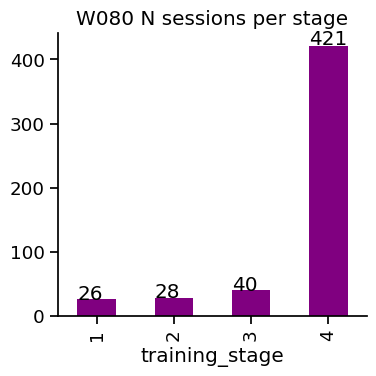

In [228]:
sns.set_context("notebook", font_scale=1.2)
ax = (W080_df.groupby("training_stage")
 .max()
 .session
 .plot.bar(
    title=f"{ANIMAL_ID} N sessions per stage",
    figsize=(4,4),
    color = 'purple'
    )
)
for p in ax.patches:
    ax.annotate(str(p.get_height()), 
                (p.get_x() * 1, 
                 p.get_height() * 1.005))

sns.despine()
plt.tight_layout()

[Text(0.5, 1.0, 'W080 Trials Per Session ~ Training Stage')]

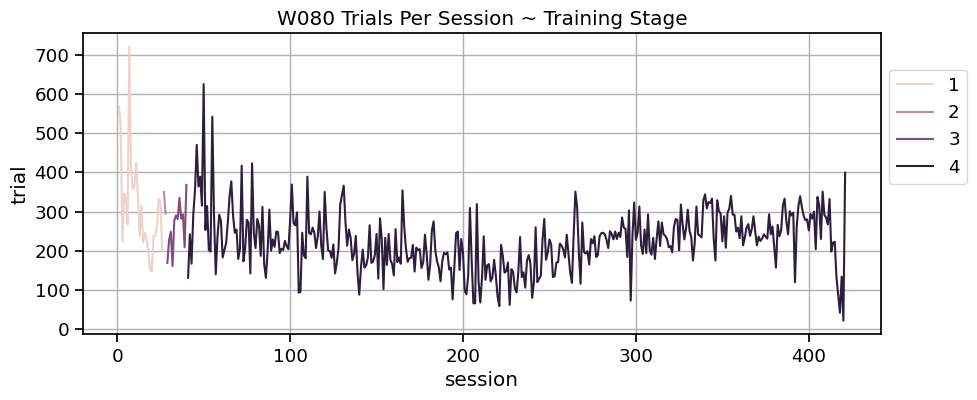

In [211]:
fig,ax = plt.subplots(figsize = (10,4))
sns.lineplot(
    data=W080_df.groupby("session").max(), 
    x="session", y="trial", hue ="training_stage"
    )

plt.grid()
plt.legend(loc=(1.01,0.5))
plt.tight_layout()
ax.set(title=f"{ANIMAL_ID} Trials Per Session ~ Training Stage")

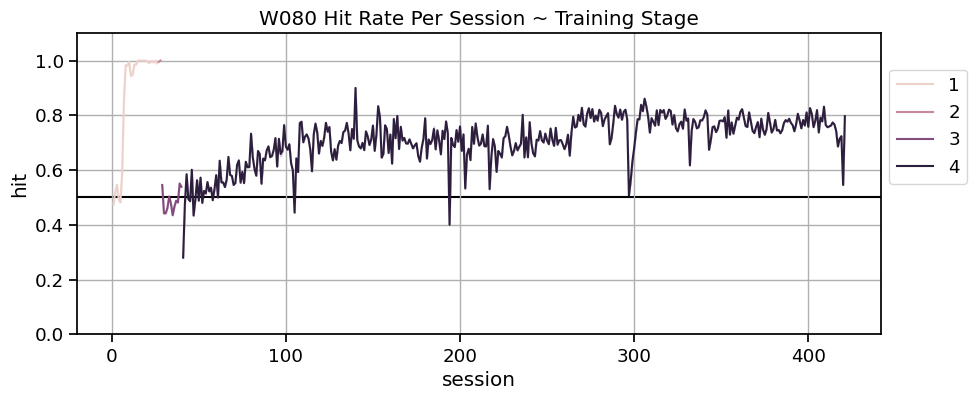

In [215]:
fig,ax = plt.subplots(figsize = (10,4))
sns.lineplot(
    data=W080_df, x="session", y ="hit", 
    hue="training_stage", errorbar=['ci', False]
    )

plt.grid()
plt.axhline(y=0.5,zorder=1, color='k')
plt.legend(loc=(1.01,0.5))
plt.ylim(0,1.1)
plt.tight_layout()
_= ax.set(title=f"{ANIMAL_ID} Hit Rate Per Session ~ Training Stage")


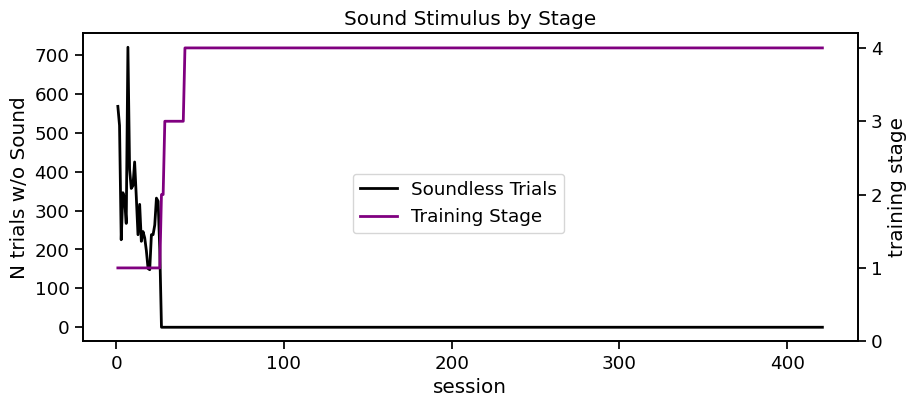

In [222]:
fig,ax = plt.subplots(figsize = (10,4))

sns.lineplot(
    W080_df["s_a"].isnull().groupby(W080_df['session']).sum(),
    ax=ax, color = "black", linewidth=2,
    label= "Soundless Trials", legend=False
    )

ax2=plt.twinx()
sns.lineplot(
    W080_df.groupby("session").training_stage.max(),
    ax=ax2, color="purple", linewidth=2,
    label="Training Stage", legend=False
    )

ax.set(ylabel= "N trials w/o Sound", title="Sound Stimulus by Stage")
ax2.set(ylabel= "training stage",ylim=(0, 4.2))
fig.legend(loc="center")



## Mistrials

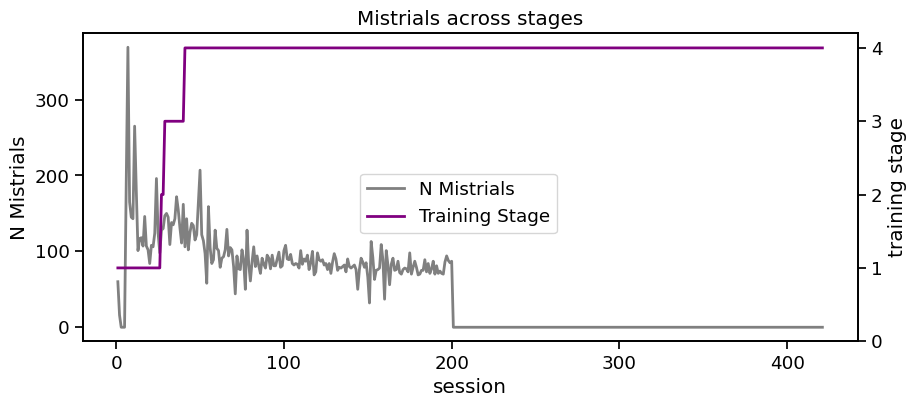

In [230]:
fig,ax = plt.subplots(figsize = (10,4))

sns.lineplot(
    W080_df["hit"].isnull().groupby(W080_df['session']).sum(),
    ax=ax, color = "gray", linewidth=2,
    label= "N Mistrials", legend=False
    )

ax2=plt.twinx()
sns.lineplot(
    W080_df.groupby("session").training_stage.max(),
    ax=ax2, color="purple", linewidth=2,
    label="Training Stage", legend=False
    )

ax.set(ylabel= "N Mistrials", title="Mistrials across stages")
ax2.set(ylabel= "training stage",ylim=(0, 4.2))
fig.legend(loc="center")


## Delays

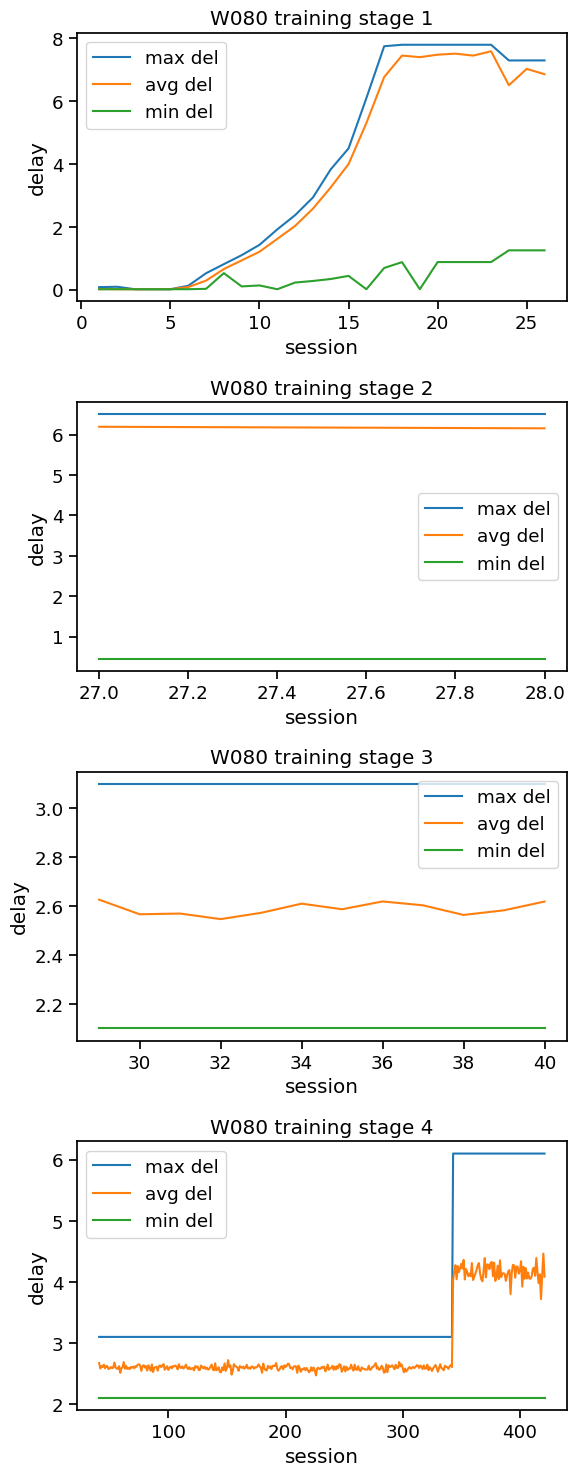

In [253]:
fig, ax = plt.subplots(4,1, figsize=(6,15))
for ii, (ts, sub_df) in enumerate(W080_df.groupby("training_stage")):
    sns.lineplot(
        sub_df.groupby("session").delay.max(), 
        label="max del", ax=ax[ii] 
        ).set(title=f"{ANIMAL_ID} training stage {ts}")
    sns.lineplot(
        sub_df.groupby("session").delay.mean(), 
        label="avg del", ax=ax[ii] 
        ).set(title=f"{ANIMAL_ID} training stage {ts}")
    sns.lineplot(
        sub_df.groupby("session").delay.min(), 
        label="min del", ax=ax[ii]
        )
plt.tight_layout()

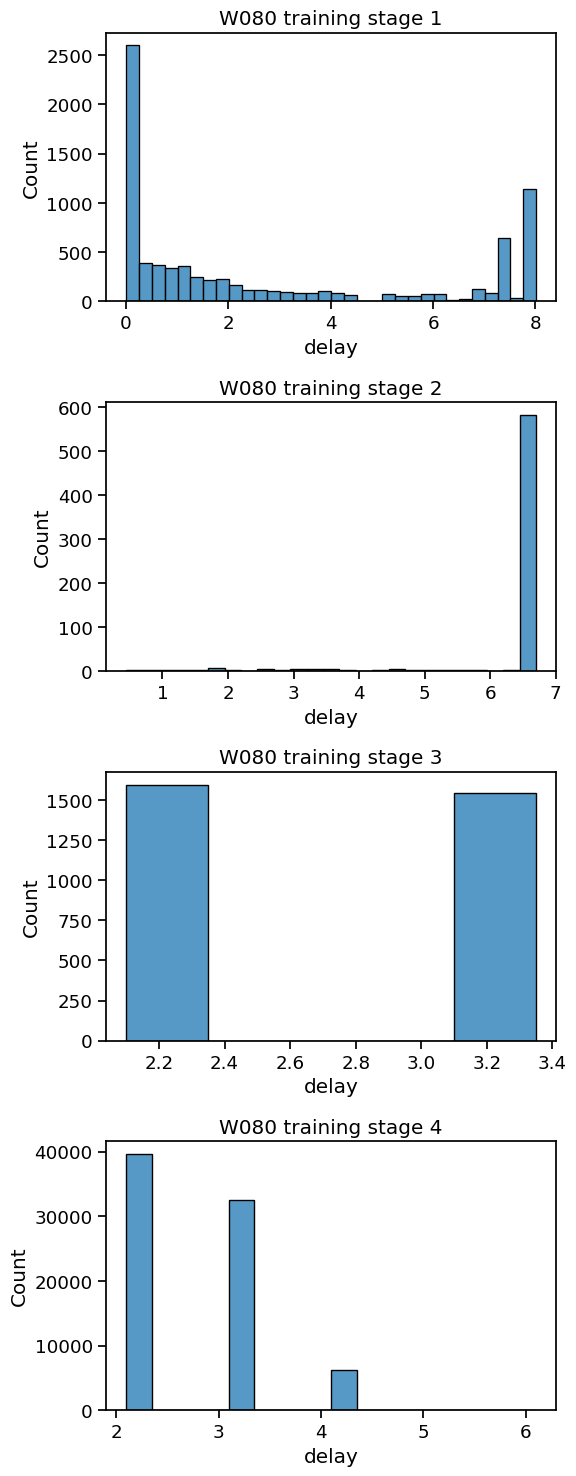

In [257]:

fig, ax = plt.subplots(4,1, figsize=(6,15))
for ii, (ts, sub_df) in enumerate(W080_df.groupby("training_stage")):
    sns.histplot(sub_df.delay, binwidth=0.25, ax=ax[ii]).set(title=f"{ANIMAL_ID} training stage {ts}")
        
plt.tight_layout()

## Sound Pairs

In [37]:
W080_df.groupby(["s_a", "s_b"]).size().reset_index().rename(columns={0:'count'})

,s_a,s_b,count
0,60.0,68.0,14436
1,68.0,60.0,10247
2,68.0,76.0,8863
3,68.5,76.0,345
4,71.5,76.0,347
5,74.5,76.0,363
6,76.0,68.0,10176
7,76.0,84.0,8952
8,77.5,76.0,396
9,80.5,76.0,383
